In [2]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from keras.models import Sequential

Populating the interactive namespace from numpy and matplotlib


In [3]:
dataset_train=pd.read_csv('./input/PM_train.txt',sep=' ',header=None).drop([26,27],axis=1)
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
dataset_train.columns=col_names
print('Shape of Train dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Train dataset:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
dataset_test=pd.read_csv('./input/PM_test.txt',sep=' ',header=None).drop([26,27],axis=1)
dataset_test.columns=col_names
#dataset_test.head()
print('Shape of Test dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Test dataset:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
pm_truth=pd.read_csv('./input/PM_truth.txt',sep=' ',header=None).drop([1],axis=1)
pm_truth.columns=['more'] #Die Spalte wird als More definiert (die Zeit die die Turbiene nach dem Test noch hätte laufen können)
pm_truth['id']=pm_truth.index+1 #es wird zu jedem Test eine id (Laufvariable) hinzugefügt (shape jetzt = (100, 2))
pm_truth.head()

,more,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [6]:
# generate column max for test data
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index() #von jeder id (1...100) wird der Maximalwert gesucht
rul.columns = ['id', 'max']
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [7]:
# run to failure
pm_truth['rtf']=pm_truth['more']+rul['max'] 
pm_truth.head()

,more,id,rtf
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [8]:
pm_truth.drop('more', axis=1, inplace=True)

dataset_test=dataset_test.merge(pm_truth,on=['id'],how='left') #die "run till falure" (rtf) wird der entsprechenden id hinzugefügt
dataset_test['ttf']=dataset_test['rtf'] - dataset_test['cycle'] #aus der rtf wird die "time till falilure" (ttf) berechent
dataset_test.drop('rtf', axis=1, inplace=True) #die rtf wird wieder herausgeworfen
dataset_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [9]:
dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max)-dataset_train['cycle']
dataset_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [10]:
df_train=dataset_train.copy()
df_test=dataset_test.copy()
period=30
df_train['label_bc'] = df_train['ttf'].apply(lambda y: 1 if y <= period else 0)
df_test['label_bc'] = df_test['ttf'].apply(lambda y: 1 if y <= period else 0) #same
df_test.head(2435)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,20,180,0.0012,-0.0004,100.0,518.67,643.13,1598.52,1419.75,14.62,...,8139.04,8.5414,0.03,394,2388,100.0,38.55,23.1112,20,1
2431,20,181,0.0007,-0.0004,100.0,518.67,643.74,1606.18,1423.78,14.62,...,8145.65,8.4790,0.03,395,2388,100.0,38.61,23.2107,19,1
2432,20,182,-0.0008,-0.0005,100.0,518.67,643.54,1589.93,1421.09,14.62,...,8139.41,8.4677,0.03,396,2388,100.0,38.66,23.1186,18,1
2433,20,183,0.0008,0.0003,100.0,518.67,643.33,1604.18,1423.09,14.62,...,8137.63,8.5354,0.03,397,2388,100.0,38.51,23.1460,17,1


In [11]:
features_col_name=['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
                   's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
target_col_name='label_bc'

In [12]:
sc=MinMaxScaler()
df_train[features_col_name]=sc.fit_transform(df_train[features_col_name])
df_test[features_col_name]=sc.transform(df_test[features_col_name])
shape(df_train)

(20631, 28)

In [16]:
# generate X_train (keine)
X_train = df_train[features_col_name]

# generate y_train
Y_train= df_train[target_col_name]

# generate X_test
X_test = df_test[features_col_name]

# generate y_test
Y_test = df_test[target_col_name]
df_train[features_col_name].head()
df_train[target_col_name].head()
df_test[features_col_name].head()
df_test[target_col_name].head()

0    0
1    0
2    0
3    0
4    0
Name: label_bc, dtype: int64

# feature enginering

# knn Model

In [224]:
array = zeros(50)

for i in range (1, array.shape[0]):
    logreg = LogisticRegression(C=i).fit(X_train, Y_train) # C: Unregelmädigkeitsfaktor
    array [i] = logreg.score(X_test, Y_test)

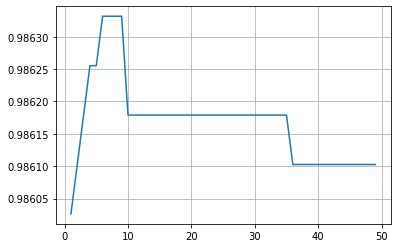

In [214]:
# Unregelmäsigkeitsfaktor "C"
C = arange(0, array.shape[0])
plot(C[1:50], array[1:50])
grid(True)
# bei C = 4...8: höchste Genauigkeit

In [234]:
 logreg = LogisticRegression(C=6).fit(X_train, Y_train) # C: unregelmädigkeitsfaktor
print(logreg.score(X_test, Y_test))

0.9860262675626146


In [218]:
prediction = logreg.predict(X_test)
print(prediction)

[0 0 0 ... 1 1 1]


In [219]:
confusion_matrix = confusion_matrix(Y_test, prediction)
accuracy = (confusion_matrix[0,0]+confusion_matrix[1,1])/(confusion_matrix[0,0]+confusion_matrix[0,1]+confusion_matrix[1,0]+confusion_matrix[1,1])
print('Confusion Matrix: \n',confusion_matrix)
print(accuracy)

Confusion Matrix: 
 [[12719    45]
 [  134   198]]
0.9863317043372022


In [230]:
real = confusion_matrix = confusion_matrix(Y_test, Y_test)
print(real)

[[12764     0]
 [    0   332]]


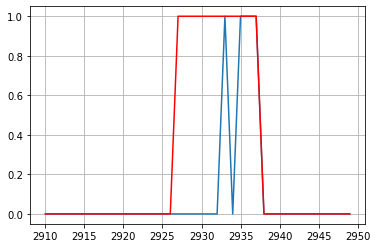

In [221]:
t = arange(0, prediction.shape[0])

#Ausschnitt
a = 2910
e = 2950

plot(t[a:e], prediction[a:e])
#plot(t[a:e], (prediction[a:e] - Y_test[a:e])) #Falsch Positiv = 1, Flasch Negativ = -1
plot(t[a:e], Y_test[a:e], 'r')
grid(True)